#### Import required libs

In [76]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
sys.path.append('../ADL4CV_project/')
import src

import numpy as np
import tensorflow as tf
import re
import math
import io
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output

import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar
from tensorflow.python.client import device_lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.insert(0, '/Users/jlee/Desktop/JONG/TUM/18W/\
Advanced_Deep_Learning_for_Computer_Vision/project/data')

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17445472360613635407
]


#### Load the dataset

In [4]:
train, val, test = src.load_datasets()

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


In [5]:
X_train, T_train, X_val, T_val, X_test, T_test = src.split_datasets(
            train, val, test)

Shape of training data:  (7500, 64, 64, 1) 
Shape of training truth:  (7500, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)


In [6]:
X_train.shape

(7500, 64, 64, 1)

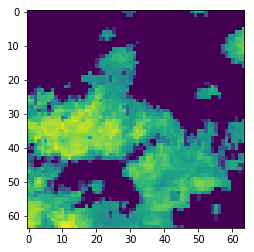

In [7]:
plt.imshow(X_train[0,:,:,0])

### WGAN-GP
    reference sources:
* https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
* https://myurasov.github.io/2017/09/24/wasserstein-gan-keras.html
* https://github.com/bobchennan/Wasserstein-GAN-Keras/blob/master/mnist_wacgan.py
* https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py

#### Special Loss functions for WGAN-GP

In [8]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [9]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the loss function
    that penalizes the network if the gradient norm moves away from 1. However, it is impossible to evaluate
    this function at all points in the input space. The compromise used in the paper is to choose random points
    on the lines between real and generated samples, and check the gradients at these points. Note that it is the
    gradient w.r.t. the input averaged samples, not the weights of the discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator and evaluate the loss.
    Then we get the gradients of the discriminator w.r.t. the input averaged samples.
    The l2 norm and penalty can then be calculated for this gradient.
    Note that this loss function requires the original averaged samples as input, but Keras only supports passing
    y_true and y_pred to loss functions. To get around this, we make a partial() of the function with the
    averaged_samples argument, and use that for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

#### Generator Architecture

In [10]:
def build_G_Unet(input_shape=(64, 64, 1), dropout=0.0, batchnorm=False):
    init = Input(shape=input_shape)
    ConvDown1 = Conv2D(filters=32, kernel_size=(2, 2), strides=(1, 1), padding="same")(init)
    if batchnorm:
        ConvDown1 = BatchNormalization()(ConvDown1)
    Lr1 = LeakyReLU(alpha=0.1)(ConvDown1)
    if (dropout > 0) and (dropout <= 1):
        Lr1 = Dropout(dropout)(Lr1)
    # 64
    ConvDown2 = Conv2D(filters=32, kernel_size=(2, 2), strides=(2, 2), padding="same")(Lr1)
    if batchnorm:
        ConvDown2 = BatchNormalization()(ConvDown2)
    Lr2 = LeakyReLU(alpha=0.1)(ConvDown2)
    if (dropout > 0) and (dropout <= 1):
        Lr2 = Dropout(dropout)(Lr2)
    # 32
    ConvDown3 = Conv2D(filters=32, kernel_size=(2, 2), strides=(2, 2), padding="same")(Lr2)
    if batchnorm:
        ConvDown3 = BatchNormalization()(ConvDown3)
    Lr3 = LeakyReLU(alpha=0.1)(ConvDown3)
    if (dropout > 0) and (dropout <= 1):
        Lr3 = Dropout(dropout)(Lr3)
    # 16
    ConvDown4 = Conv2D(filters=32, kernel_size=(2, 2), strides=(2, 2), padding="same")(Lr3)
    if batchnorm:
        ConvDown4 = BatchNormalization()(ConvDown4)
    Lr4 = LeakyReLU(alpha=0.1)(ConvDown4)
    if (dropout > 0) and (dropout <= 1):
        Lr4 = Dropout(dropout)(Lr4)
    # 8
    ConvDown5 = Conv2D(filters=64, kernel_size=(2, 2), strides=(2, 2), padding="same")(Lr4)
    if batchnorm:
        ConvDown5 = BatchNormalization()(ConvDown5)
    Lr5 = LeakyReLU(alpha=0.1)(ConvDown5)
    if (dropout > 0) and (dropout <= 1):
        Lr5 = Dropout(dropout)(Lr5)
    # 4

    # 8
    UpSamp1 = UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
    merge1 = concatenate([ConvDown4, UpSamp1], axis=-1)
    Conv1 = Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding="same")(merge1)
    if batchnorm:
        Conv1 = BatchNormalization()(Conv1)
    Lr6 = LeakyReLU(alpha=0.1)(Conv1)
    if (dropout > 0) and (dropout <= 1):
        Lr6 = keras.layers.Dropout(dropout)(Lr6)
    # 16
    UpSamp2 = UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
    merge2 = concatenate([ConvDown3, UpSamp2], axis=-1)
    Conv2 = Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding="same")(merge2)
    if batchnorm:
        Conv2 = BatchNormalization()(Conv2)
    Lr7 = LeakyReLU(alpha=0.1)(Conv2)
    if (dropout > 0) and (dropout <= 1):
        Lr7 = Dropout(dropout)(Lr7)
    # 32
    UpSamp3 = UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)
    merge3 = concatenate([ConvDown2, UpSamp3], axis=-1)
    Conv3 = Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding="same")(merge3)
    if batchnorm:
        Conv3 = BatchNormalization()(Conv3)
    Lr8 = LeakyReLU(alpha=0.1)(Conv3)
    if (dropout > 0) and (dropout <= 1):
        Lr8 = Dropout(dropout)(Lr8)
    # 64
    UpSamp4 = UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
    merge4 = concatenate([ConvDown1, UpSamp4], axis=-1)
    Conv4 = Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding="same")(merge4)
    if batchnorm:
        Conv4 = BatchNormalization()(Conv4)
    Lr9 = LeakyReLU(alpha=0.1)(Conv4)
    if (dropout > 0) and (dropout <= 1):
        Lr9 = Dropout(dropout)(Lr9)

    Conv5 = Conv2D(filters=1, kernel_size=(4, 4), strides=(1, 1),
                                padding="same", activation='tanh')(Lr9)

    return Model(inputs=init, outputs=Conv5, name='G')

In [11]:
G = build_G_Unet(batchnorm=True)
G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

#### Spatial Discriminator Architecture

In [12]:
def build_Spatial_D(input_shape=(64, 64, 1), condition_shape=(64, 64, 1), dropout=0.3, batchnorm=False):
    # condition is the frame t (the original frame) or the sequence of past frames
    condition = Input(shape=condition_shape)
    # other is the generated prediction of frame t+1 or the ground truth frame t+1
    other = Input(shape=input_shape)
    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = Concatenate(axis=-1)([condition, other])

    conv1 = Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(combined_imgs)
    if batchnorm:
        conv1   = BatchNormalization()(conv1)
    relu1 = LeakyReLU(alpha=0.2)(conv1)
    if (dropout > 0) and (dropout <= 1):
        relu1 = Dropout(dropout)(relu1)

    conv2 = Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(relu1)
    if batchnorm:
        conv2   = BatchNormalization()(conv2)
    relu2 = LeakyReLU(alpha=0.2)(conv2)
    if (dropout > 0) and (dropout <= 1):
        relu2 = Dropout(dropout)(relu2)

    conv3 = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(relu2)
    if batchnorm:
        conv3   = BatchNormalization()(conv3)
    relu3 = LeakyReLU(alpha=0.2)(conv3)
    if (dropout > 0) and (dropout <= 1):
        relu3 = Dropout(dropout)(relu3)

    conv4 = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(relu3)
    if batchnorm:
        conv4   = BatchNormalization()(conv4)
    relu4 = LeakyReLU(alpha=0.2)(conv4)
    if (dropout > 0) and (dropout <= 1):
        relu4 = Dropout(dropout)(relu4)

    # Out: 1-dim probability
    flatten = Flatten()(relu4)
    fcl1 = Dense(1)(flatten)
    # sig1 = Activation('sigmoid', name="s_disc_output")(fcl1)
    # For WGAN, there is no activation function
    lin1 = Activation('linear', name="s_disc_output")(fcl1)

    return Model(inputs=[condition, other], outputs=lin1, name='SD')

In [13]:
SD = build_Spatial_D()
SD.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 64, 64, 2)    0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 16)   528         concatenate_5[0][0]              
__________

#### Parameter setting

In [124]:
# GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

# random seed
RND = 777
np.random.seed(RND)

BATCH_SIZE = 16
ITERATIONS = 20000
D_ITERS = 10

K.set_image_dim_ordering('tf')

In [125]:
D = build_Spatial_D(batchnorm=True)

D.compile(
    optimizer = RMSprop(lr=0.00005),
    loss = wasserstein_loss)

condition = Input(shape=(64, 64, 1), name='input_condition_')
other = Input(shape=(64, 64, 1),name='input_other_')

G = build_G_Unet(batchnorm=True)

# create combined D(G) model
output_is_fake = D(inputs = [condition, G(condition)])
DG = Model(condition, outputs=output_is_fake)

DG.summary()

DG.compile(
    optimizer = RMSprop(lr=0.00005),
    loss = wasserstein_loss
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_condition_ (InputLayer)   (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
G (Model)                       (None, 64, 64, 1)    170177      input_condition_[0][0]           
__________________________________________________________________________________________________
SD (Model)                      (None, 1)            175793      input_condition_[0][0]           
                                                                 G[1][0]                          
Total params: 345,970
Trainable params: 344,850
Non-trainable params: 1,120
__________________________________________________________________________________________________


#### Training

In [ ]:
import warnings; warnings.simplefilter('ignore')

progress_bar = Progbar(target=ITERATIONS)

DG_losses = []
D_true_losses = []
D_fake_losses = []

In [ ]:
for it in range(ITERATIONS):

    if len(D_true_losses) > 0:
        progress_bar.update(
            it,
            values=[ # avg of 5 most recent
                    ('D_real_is_fake', np.mean(D_true_losses[-5:], axis=0)),
                    ('D_fake_is_fake', np.mean(D_fake_losses[-5:], axis=0)),
                    ('D(G)_is_fake', np.mean(DG_losses[-5:],axis=0))
            ]
        )
        
    else:
        progress_bar.update(it)
        
    # 1: train D on real+generated images

    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 100
    else:
        d_iters = D_ITERS

    for d_it in range(d_iters):

        # unfreeze D
        D.trainable = True
        for l in D.layers: l.trainable = True

        # clip D weights

        for l in D.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)

        # 1.1: maximize D output on reals === minimize -1*(D(real))

        # draw random samples from real images
        index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
        base_images = X_train[index]
        real_images = T_train[index]

        D_loss = D.train_on_batch([base_images, real_images], -np.ones(BATCH_SIZE))
        #print(D_loss)
        D_true_losses.append(D_loss)

        # 1.2: minimize D output on fakes 

        generated_images = G.predict(base_images)

        D_loss = D.train_on_batch([base_images, generated_images], np.ones(BATCH_SIZE))
        #print(D_loss)
        D_fake_losses.append(D_loss)

    # 2: train D(G) (D is frozen)
    # minimize D output while supplying it with fakes, 
    # telling it that they are reals (-1)

    # freeze D
    D.trainable = False
    for l in D.layers: l.trainable = False
        
    index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
    base_images = X_train[index]

    DG_loss = DG.train_on_batch(base_images,-np.ones(BATCH_SIZE))
    DG_losses.append(DG_loss)

#    if it % 10 == 0:
#        update_tb_summary(it, write_sample_images=(it % 250 == 0))

12514/20000 [=================>............] - ETA: 12:52:56 - D_real_is_fake: -0.1661 - D_fake_is_fake: 0.1677 - D(G)_is_fake: -0.1660

In [ ]:
G.save_weights('/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/results/wgan_results/iter_20000_RMSprop_0.00005/G_model.h5')
D.save_weights('/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/results/wgan_results/iter_20000_RMSprop_0.00005/D_model.h5')
DG.save_weights('/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/results/wgan_results/iter_20000_RMSprop_0.00005/DG_model.h5')

In [ ]:
G_imgs = G.predict(X_test)

In [ ]:
plt.imshow(T_test[1,:,:,0])

In [ ]:
plt.imshow(G_imgs[1,:,:,0])

#### Plot the training curve

In [ ]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

g_labels = ["Generator loss"]
#loop over gen loss components
#for curve in range(np.shape(gan.log["g_loss"])[-1]):
ax.plot(DG_losses, c="g", label="G_loss")

ax.plot(D_true_losses, alpha=0.3, c="b")
ax.plot(src.smooth(D_true_losses) ,label="D_true_loss", c="b")
ax.plot(D_fake_losses, alpha=0.6, c="orange")
ax.plot(src.smooth(D_fake_losses),label="D_fake_loss", c="orange")
ax.grid()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc="best")

#plt.savefig(f"best_GAN_training_1_{gan.g_dropout}_{gan.d_dropout}.png") #g dropout, d dropout, g batchnorm, noisy labels, loss weights, augment

In [ ]:
import importlib.util
spec = importlib.util.spec_from_file_location("src.py", "/Users/jlee/Desktop/JONG/TUM/18W/Advanced_Deep_Learning_for_Computer_Vision/project/ADL4CV_project/src.py")
src = importlib.util.module_from_spec(spec)
spec.loader.exec_module(src)
#import importlib as imp
#imp.reload(src)

In [ ]:
error_images, error_vals, error_means = src.error_distribution(T_test, G_imgs, metric="difference")

In [ ]:
error_images.shape

In [ ]:
src.result_plotter(range(5), (X_test[:,:,:,0], T_test[:,:,:,0], G_imgs[:,:,:,0], error_images[:,:,:,0]), save=False)